<a href="https://colab.research.google.com/github/ThabangDLebese/Training_Gans/blob/master/Training_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Implementation of basic GANs**

This is a simple implementation of basic GANs. I code this to deep my understanding of how GANs work. This code use MNIST dataset, which is perfectly processed in TensorFlow with some very convenient functions. The shape of input tensor is [None, 100], which indicates a hunderd latent features. This idea is borrowed from DCGANs, in which every generated image is initilally from one 100-dimention vector.

Because MNIST dataset is simple and small, the structures of generator and discriminator in this code are simple.

Generator: Input layer is 100 dimension. The generator includes two layers, first layer with 128 nodes and second layer with 784 nodes. The reason why the last layer is 784 dimension is that every image in MNIST dataset is 28 by 28 pixels.

Discriminator: Input layer is 784 dimension. The discrimonator includes two layers, first layer with 128 nodes and second layer with 1 node. The last layer only contains one node, because we want to get a number within 0 to 1, which will be used to indicate the confidence of input image is real.

For every random generated 100-dimensional vector, it will result in a image, which means this generated adversrial networks will model the distribution of data distribution. In this sense, every image is a data point in high dimensional space. Designing and training adversarial networks turns out to be difficult. Because in GANs generator and discriminator are like two enemies which compete with each other and during the competition they both become stronger. So in order to make this competition works, we need to design generator with similar or slightly weaker capacity than discriminator. Otherwise, training process will stop. So If you change the structure of generator and discriminator, I can't guarantee it will be working.

Notes:

- To avoid nan value in loss function, we added a small scalar. For example, $tf.log(dis_2 + 1e-8)$

- The batch size in this code is fixed to 30.

- Take care to set the number of iterations of training discriminator. 
 - Discriminator has to be stronger than generator for better classification, but it cannot be too strong that it underfits rendering the generator useless.

- When training generator, tensorflow only update parameters of generator rather than entire variables in graph.

- On the GPU this code running time is less than two minutes.

The whole idea of this code is based on original by Ian GoodFellow: https://arxiv.org/pdf/1406.2661.pdf

In [0]:
import os
print("Directory: \n", os.getcwd())
print("Entries inside the Directory: \n",os.listdir(os.getcwd()))

Directory: 
 /content
Entries inside the Directory: 
 ['.config', 'sample_data']


In [0]:
from platform import python_version
print("Python:", python_version())

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings

# import warnings
# warnings.filterwarnings("ignore")
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Python: 3.6.8
TensorFlow Version: 1.15.0-rc3
Default GPU Device: /device:GPU:0


In [0]:
# import tensorflow as tf

import numpy as np
import scipy.misc
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt
import imageio
warnings.filterwarnings("ignore")

from logging import warning as warn
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Importing MNIST (Mixed National Institute of Standards and Technology) dataset
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
data = mnist.train.images[:55000,:]
print("Shape of the data:",data.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Shape of the data: (55000, 784)


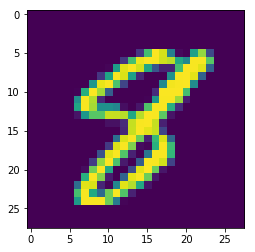

In [0]:
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest')
    return plt

batch_xs, batch_ys = mnist.test.next_batch(5)
for i in range(1):
    gen_image(batch_xs[i]).show()

In [0]:
def Generator(z, ap_var=False):
    """
    Generator function for generator in GANs.
    : param z: input initial noise, with size _ x 100
    : return: a vector, with size of _ x 784 (or flatten image)
    : Input layer is 100 dimensions. The generator includes two layers,
        first layer with 128 nodes
        second layer with 784 nodes = because every image in MNIST dataset is 28 by 28 pixels.
    """

    w1 = get_weights([100,128], 'g_w1', ap_var)
    b1 = get_biases([128], 'g_b1', ap_var)
    
    w2 = get_weights([128,784], 'g_w2', ap_var)
    b2 = get_biases([784], 'g_b2', ap_var)
    
    temp1 = tf.nn.relu(tf.matmul(z, w1) + b1)
    temp2 = tf.matmul(temp1, w2) + b2
    
    return tf.nn.sigmoid(temp2)
       

def Discriminator(z, ap_var=False):
    """
    Discriminator function for discriminator in GANs.
    : param z: input target image to be check whether it is real or not
    : return: a vector of probability, which indicates the degree of real
    : Input layer is 784 dimensions. The discrimonator includes two layers also,
        first layer with 128 nodes,
        second layer with 1 node = because we want to get a number within 0 to 1, which will be used to indicate
            the confidence of input image is real.
    """
    
    w1 = get_weights([784,128], 'd_w1', ap_var)
    b1 = get_biases([128], 'd_b1', ap_var)
    
    w2 = get_weights([128,1], 'd_w2', ap_var)
    b2 = get_biases([1], 'd_b2', ap_var)
    
    temp1 = tf.nn.relu(tf.matmul(z, w1) + b1)
    temp2 = tf.matmul(temp1, w2) + b2
    
    return tf.nn.sigmoid(temp2), b1
    
    
    
def get_weights(shape, w_name, ap_var):
    """
    Helper function to initialize weights.
    : param shape: input the shape of variable
    : param name: the name of variable
    : return: weights
    """
    
    std = 1. / np.sqrt(shape[0] / 2.)
    init = tf.constant_initializer(np.random.normal(scale=std, size=shape))
    w = tf.get_variable(name=w_name, shape=shape, initializer=init)
    
    if ap_var is True:
        
        if w_name.startswith('d'):
            var_d.append(w)
        else:
            var_g.append(w)
    
    return w


def get_biases(shape, b_name, ap_var):
    """
    Helper function to initialize biases.
    : param shape: input the shape of variable
    : param b_name: the name of variable
    : return: biases
    """
    
    init = tf.constant_initializer(0.01)
    b = tf.get_variable(name=b_name, shape=shape, initializer=init)
    
    if ap_var is True:
        
        if b_name.startswith('d'):
            var_d.append(b)
        else:
            var_g.append(b)
    
    return b


def generate_random_input(shape):
    """
    Generate random initial noise for generator input.
    : param shape: the shape of input
    : return: random noise with size = shape
    """
    
    return np.random.uniform(-1., 1., size=shape)

In [0]:
# Time this code ASAP
from datetime import datetime 
start_time = datetime.now() 

x_random = tf.placeholder(tf.float32, [None, 100])
x_train = tf.placeholder(tf.float32, [None, 784])

var_d = []
var_g = []

# build model 
gen = Generator(x_random, ap_var=True)
with tf.variable_scope('Discriminator') as scope:
    dis_1, temp2 = Discriminator(x_train, ap_var=True)
    scope.reuse_variables()
    dis_2, _ = Discriminator(gen, ap_var=False)
   
    
# define loss function
# The first thing is to maximize wrt the discriminator
# Then minimize wrt the generator
#  If we fully maximize w.r.t the discriminator, then minimiz with generator then we not going to mode collapse
loss_d = -tf.reduce_mean(tf.log(dis_1 + 1e-8) + tf.log(1.0 - dis_2 + 1e-8))
loss_g = -tf.reduce_mean(tf.log(dis_2 + 1e-8))

# define optimizer
#  Make the other network to learn faster than the other one so that the models can play catchup with each other
optimizer_d = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(loss_d, var_list=var_d) # make it fatser
optimizer_g = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_g, var_list=var_g) # Make it slower

# # define session
session = tf.Session()
session.run(tf.global_variables_initializer())

# begin training
for i in range(1000001):
    
    
    # train discriminator
    for j in range(2):         
        x, y = mnist.train.next_batch(30)
        x_rand = generate_random_input([30, 100])
        _, current_loss_d = session.run([optimizer_d,loss_d], feed_dict={x_train:x, x_random:x_rand})

        
    # train generator 
    x_rand = generate_random_input([30, 100])
    _, current_loss_g = session.run([optimizer_g,loss_g], feed_dict={x_random:x_rand})
    
    
    if i%1000 == 0:
        print('No.{} iteration'.format(i))
        print('Current loss for discriminator: {}'.format(current_loss_d))
        print('Current loss for generator: {}'.format(current_loss_g))
        print()

time_elapsed = datetime.now() - start_time 

# session.close()
print('Finished.')
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

No.0 iteration
Current loss for discriminator: 1.635526180267334
Current loss for generator: 0.44636261463165283

No.1000 iteration
Current loss for discriminator: 1.0559695959091187
Current loss for generator: 1.2078781127929688

No.2000 iteration
Current loss for discriminator: 0.8780307173728943
Current loss for generator: 1.1831746101379395

No.3000 iteration
Current loss for discriminator: 0.606158435344696
Current loss for generator: 1.5527081489562988

No.4000 iteration
Current loss for discriminator: 0.519921064376831
Current loss for generator: 1.631225824356079

No.5000 iteration
Current loss for discriminator: 0.6637604236602783
Current loss for generator: 1.2107130289077759

No.6000 iteration
Current loss for discriminator: 0.7712329626083374
Current loss for generator: 1.030112385749817

No.7000 iteration
Current loss for discriminator: 0.6034006476402283
Current loss for generator: 1.6741664409637451

No.8000 iteration
Current loss for discriminator: 0.5473961234092712
Cu

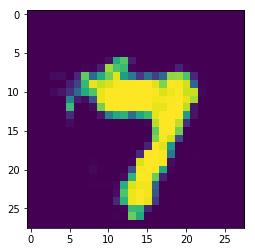

In [0]:
x_rand = generate_random_input([30, 100])
img = session.run(gen, feed_dict={x_random:x_rand})
img = img[1].reshape(28,28)
plt.imshow(img)
plt.show()

In [0]:
import glob
import cv2
import PIL

# creating a file to write the restults in
GANsfile = r'/content/Result_GANs/' 
if not os.path.exists(GANsfile):
    os.makedirs(GANsfile)


In [0]:

# Writing the restults to a new file
files = glob.glob('/content/Result_GANs/*')
for f in files:
    os.remove(f)

IsADirectoryError: ignored

In [0]:
# save generated new images
for i in range(100):
    x_rand = generate_random_input([30, 100])
    img = session.run(gen, feed_dict={x_random:x_rand})
    img1 = img[0].reshape(28,28)
    img2 = img[1].reshape(28,28)
    imageio.imsave(uri = 'Result_GANs/img{}_generated.jpg'.format(i),format='.jpg', im = img2)

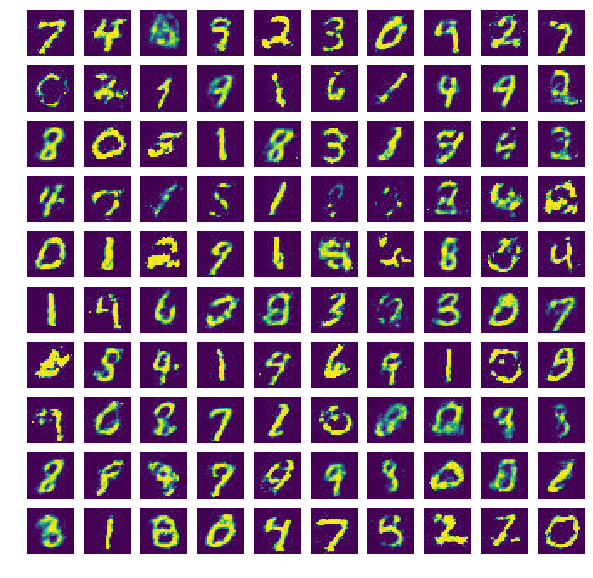

In [0]:
import glob
import cv2
import PIL

generated_mnist = glob.glob('/content/Result_GANs/*')
fig = plt.figure(figsize=(10, 10))
for num, x in enumerate(generated_mnist):
    img = PIL.Image.open(x)
    plt.subplot(10, 10, num+1)
    plt.axis('off')
    plt.imshow(img)

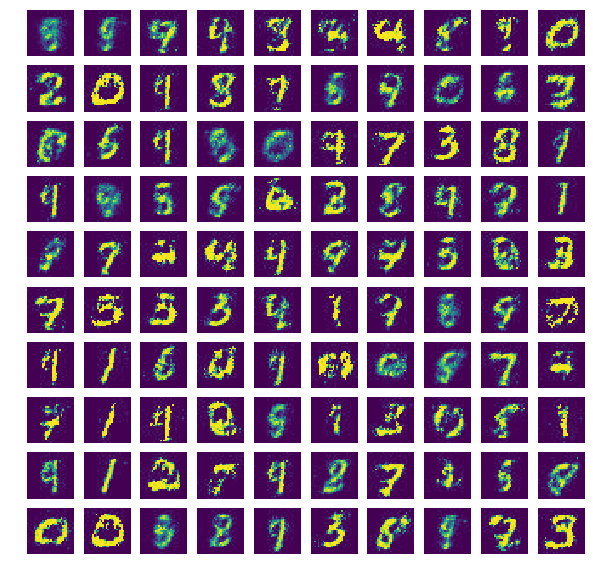

In [0]:
import glob
import cv2
import PIL

generated_mnist = glob.glob('/content/Result_GANs/*')
fig = plt.figure(figsize=(10, 10))
for num, x in enumerate(generated_mnist):
    img = PIL.Image.open(x)
    plt.subplot(10, 10, num+1)
    plt.axis('off')
    plt.imshow(img)